In [1]:
!pip install --user --upgrade google-cloud-bigquery

     |████████████████████████████████| 170 kB 5.2 MB/s eta 0:00:01


In [2]:
!pip install --user --upgrade google-cloud-monitoring

     |████████████████████████████████| 235 kB 4.5 MB/s eta 0:00:01


In [3]:
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
from google.cloud import bigquery

In [6]:
client = bigquery.Client()

In [7]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE DEP_DELAY >= 10 AND RAND() < 0.01
"""
df = client.query(sql).to_dataframe()
df.describe()

,ARR_DELAY,DEP_DELAY
count,12945.000000,13025.000000
mean,45.835071,50.719616
std,62.773347,60.925056
min,-36.000000,10.000000
25%,11.000000,17.000000
50%,27.000000,30.000000
75%,58.000000,60.000000
max,1456.000000,1458.000000


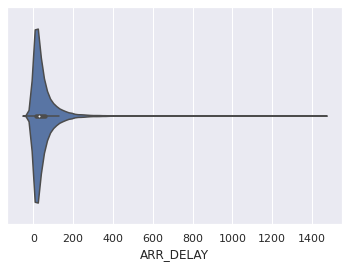

In [8]:
sns.set_style("whitegrid")
sns.set(font="DejaVu Sans")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')

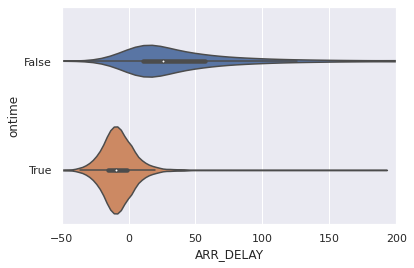

In [9]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001
"""
df = client.query(sql).to_dataframe()
df['ontime'] = df['DEP_DELAY'] < 10
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime',
                    inner='box', orient='h')
ax.set_xlim(-50, 200);

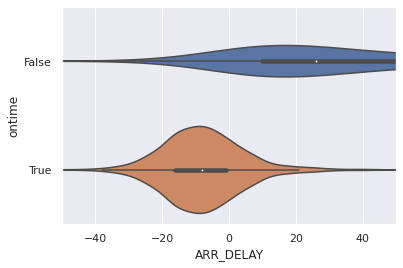

In [10]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001
"""
df = client.query(sql).to_dataframe()
df['ontime'] = df['DEP_DELAY'] < 10
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime',
                    inner='box', orient='h', gridsize=1000)
ax.set_xlim(-50, 50);

In [11]:
depdelayquery = """
SELECT
  DEP_DELAY,
  arrival_delay,
  stddev_arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""
depdelay = client.query(depdelayquery).to_dataframe()
depdelay.head()

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-23.0,-23.888646,11.432163,458
1,-22.0,-23.227488,12.590133,633
2,-21.0,-22.299781,11.558313,914
3,-20.0,-21.407821,12.066489,1432
4,-19.0,-20.430769,11.910134,1950


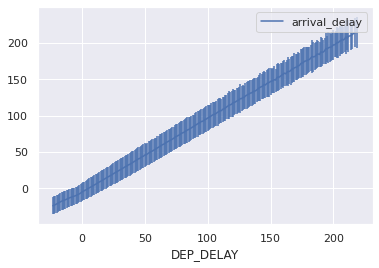

In [12]:
ax = depdelay.plot(kind='line',
                   x='DEP_DELAY',
                   y='arrival_delay',
                   yerr='stddev_arrival_delay');

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


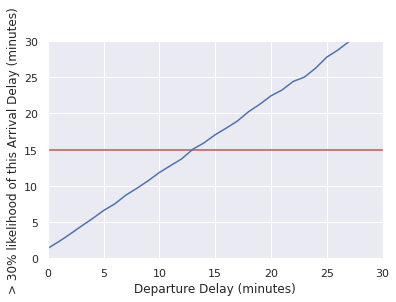

In [13]:
Z_30 = 0.52
depdelay['arr_delay_30'] = (
  (Z_30 * depdelay['stddev_arrival_delay'])
  + depdelay['arrival_delay']
)
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line',
              x='DEP_DELAY',
              y='arr_delay_30',
              ax=ax,
              ylim=(0, 30),
              xlim=(0, 30),
              legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)');